In [1]:
import pandas as pd
import numpy as np

In [2]:
df_data = pd.read_csv("dauerzaehlstellen_data copy.csv",sep=",",dtype={"ZNR": str})
df_loc = pd.read_csv("dauerzaehlstellen_location copy.csv",sep=",",dtype={"ZNR": str})

df_data.replace(-29, pd.NA, inplace=True)

if df_data["TVMAXT"].dtype == object:
    df_data["TVMAXT"] = df_data["TVMAXT"].str.replace(r"\*", "", regex=True)

df_loc_small = df_loc[["ZNR", "BEZIRK_NR"]]
df = df_data.merge(df_loc_small, on="ZNR", how="left")
df = df.dropna(subset=["BEZIRK_NR"])
df["BEZIRK_NR"] = df["BEZIRK_NR"].astype(int)

df["Area_Type"] = df["BEZIRK_NR"].apply(lambda x: "City Centre" if 1 <= x <= 9 else "Suburb")

print(df[["ZNR", "ZNAME", "DATUM", "BEZIRK_NR", "Area_Type"]].drop_duplicates().head(10))

     ZNR                 ZNAME       DATUM  BEZIRK_NR    Area_Type
0   1075          Reichsbrücke  2024-12-01         22       Suburb
6   1078           Westbahnhof  2024-12-01          6  City Centre
12  1089       Floridsdorf-Br.  2024-12-01         20       Suburb
18  1096  Brigittenauer Brücke  2024-12-01         20       Suburb
24  1131            Karlsplatz  2024-12-01          1  City Centre
30  1170     Donaukanal Straße  2024-12-01          2  City Centre
36  1177            Handelskai  2024-12-01          2  City Centre
42  1179        Brunner Straße  2024-12-01         23       Suburb
48  1180            Hochstraße  2024-12-01         23       Suburb
54  1181  Breitenfurter Straße  2024-12-01         23       Suburb


In [5]:
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [ ]:
df_data = pd.read_csv("dauerzaehlstellen_data copy.csv",sep=",",dtype={"ZNR": str},parse_dates=["DATUM"])
df_loc = pd.read_csv("dauerzaehlstellen_location copy.csv",sep=",",dtype={"ZNR": str})
df = (df_data.merge(df_loc[["ZNR","BEZIRK_NR"]], on="ZNR", how="left").dropna(subset=["BEZIRK_NR"]))
df["BEZIRK_NR"] = df["BEZIRK_NR"].astype(int)
df["Area_Type"] = df["BEZIRK_NR"].apply(lambda x: "City Centre" if 1<=x<=9 else "Suburb")

21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:37 - cmdstanpy - INFO - Chain [1] done processing
21:33:26 - cmdstanpy - INFO - Chain [1] start processing
21:34:58 - cmdstanpy - INFO - Chain [1] done processing


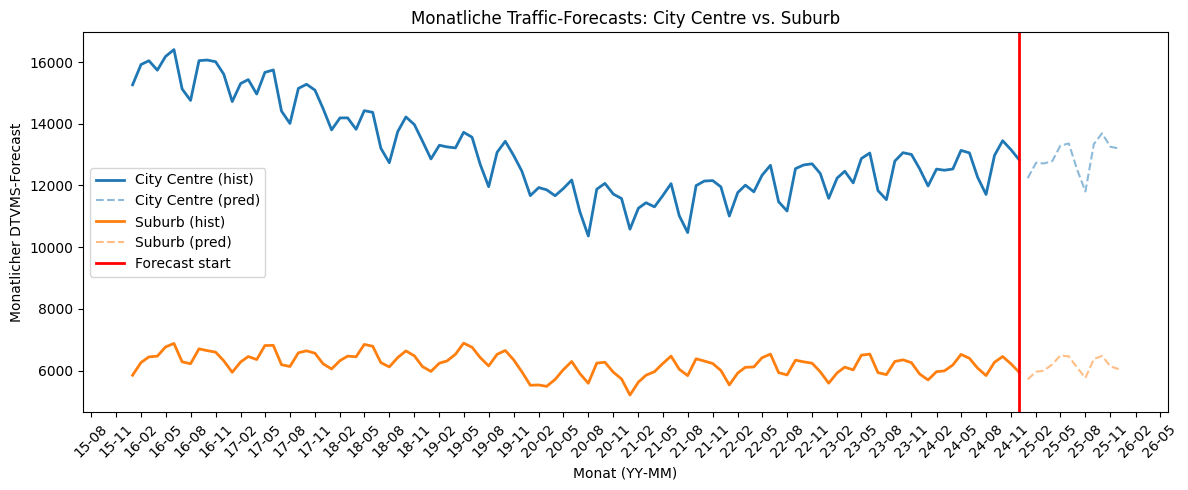

In [7]:

train_end = df["DATUM"].max()

def make_daily_df(df_area):
    rows=[]
    for _,r in df_area.iterrows():
        start = r["DATUM"].replace(day=1)
        end   = start + pd.offsets.MonthEnd(0)
        for d in pd.date_range(start,end,freq="D"):
            wd=d.weekday()
            if wd==0:    y=r["DTVMO"]
            elif 1<=wd<=3: y=r["DTVDD"]
            elif wd==4:  y=r["DTVFR"]
            elif wd==5:  y=r["DTVSA"]
            else:        y=r["DTVSF"]
            rows.append({"ds":d,"y":y})
    return pd.DataFrame(rows).dropna().sort_values("ds").reset_index(drop=True)

results={}
for area in ["City Centre","Suburb"]:
    daily = make_daily_df(df[df["Area_Type"]==area])
    m = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    m.fit(daily)
    future = m.make_future_dataframe(periods=365,freq="D")
    fc = m.predict(future)
    results[area] = {"daily_df":daily, "forecast":fc}


monthly_plot=None
for area,data in results.items():
    fc = data["forecast"].copy()
    fc["month"] = fc["ds"].dt.to_period("M").dt.to_timestamp()
    mf = fc.groupby("month")["yhat"].mean().rename(area)
    monthly_plot = mf.to_frame() if monthly_plot is None else monthly_plot.join(mf,how="outer")

fig, ax = plt.subplots(figsize=(12,5))

mask_hist = monthly_plot.index <= train_end
mask_fut  = monthly_plot.index >  train_end

for area,color in [("City Centre","C0"),("Suburb","C1")]:
    ax.plot(monthly_plot.index[mask_hist], monthly_plot[area][mask_hist],
            color=color, label=f"{area} (hist)", linewidth=2)
    ax.plot(monthly_plot.index[mask_fut], monthly_plot[area][mask_fut],
            linestyle="--", color=color, alpha=0.5, label=f"{area} (pred)")

ax.axvline(train_end, color="red", linewidth=2, label="Forecast start")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m"))
plt.xticks(rotation=45)
plt.xlabel("Monat (YY‑MM)")
plt.ylabel("Monatlicher DTVMS‑Forecast")
plt.title("Monatliche Traffic‑Forecasts: City Centre vs. Suburb")
plt.legend()
plt.tight_layout()
plt.show()



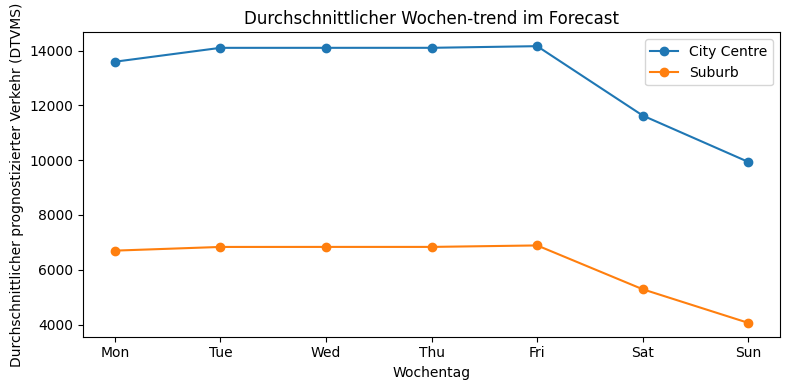

In [8]:
weekly_patterns = {}
for area, data in results.items():
    fc = data["forecast"].copy()
    fc["weekday"] = fc["ds"].dt.weekday
    weekly_avg = fc.groupby("weekday")["yhat"].mean()
    weekly_patterns[area] = weekly_avg

plt.figure(figsize=(8, 4))
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

for area, pattern in weekly_patterns.items():
    pattern = pattern.reindex(range(7))
    plt.plot(days, pattern.values, marker="o", label=area)

plt.title("Durchschnittlicher Wochen­trend im Forecast")
plt.xlabel("Wochentag")
plt.ylabel("Durchschnittlicher prognostizierter Verkehr (DTVMS)")
plt.legend()
plt.tight_layout()
plt.show()

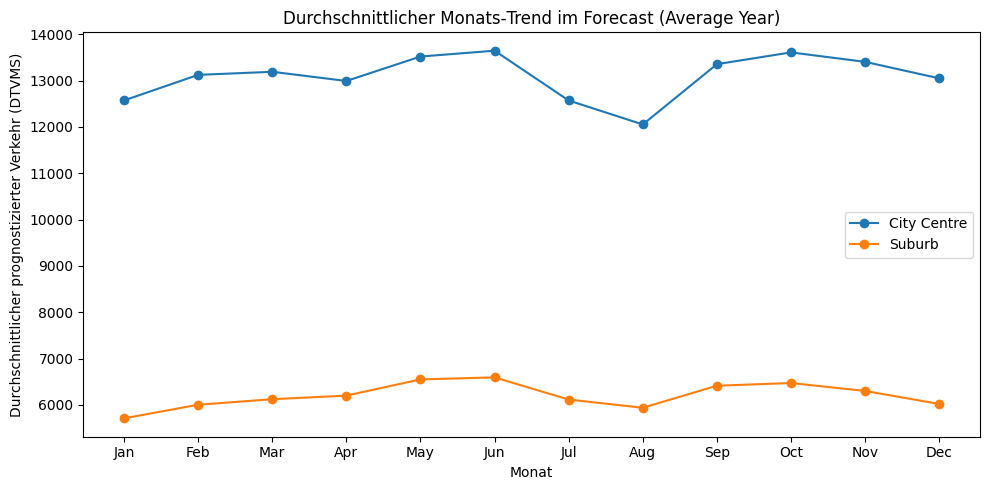

In [9]:
import calendar

monthly_patterns = {}
for area, data in results.items():
    fc = data["forecast"].copy()
    fc["month"] = fc["ds"].dt.month
    monthly_avg = (
        fc.groupby("month")["yhat"]
          .mean()
          .reindex(range(1, 13)) 
    )
    monthly_patterns[area] = monthly_avg

plt.figure(figsize=(10, 5))

months = [calendar.month_abbr[i] for i in range(1, 13)]

for area, pattern in monthly_patterns.items():
    plt.plot(months, pattern.values, marker="o", label=area)

plt.title("Durchschnittlicher Monats‑Trend im Forecast (Average Year)")
plt.xlabel("Monat")
plt.ylabel("Durchschnittlicher prognostizierter Verkehr (DTVMS)")
plt.legend()
plt.tight_layout()
plt.show()